In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sns.set()

In [66]:
##### obtain data #####
data = pd.read_csv('cardio_train.csv')
data.head() # age is given in days, not years, can change that later if needed 

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [67]:
 print(len(data)) # 70k samples should help w cross validation

70000


In [68]:
##### Begin analyzing and cleaning data #####
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
id             70000 non-null int64
age            70000 non-null int64
gender         70000 non-null int64
height         70000 non-null int64
weight         70000 non-null float64
ap_hi          70000 non-null int64
ap_lo          70000 non-null int64
cholesterol    70000 non-null int64
gluc           70000 non-null int64
smoke          70000 non-null int64
alco           70000 non-null int64
active         70000 non-null int64
cardio         70000 non-null int64
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [69]:
# inspect data to see if any issues are present
data.describe() # also gives convenient access to significant measures for each category such as mean, std, etc.
# transpose for easier view of measurements
data.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


In [116]:
# avg age is approx. 53 yrs w std 6.75 yrs, youngest person is ~29 ** objective
# gender is categorical 1 & 2, women and men, respectively ** objective
# height in cm ** objective
# weight in kg ***** min weight is 10 kg???? ***** ** objective
# ap_hi == Systolic blood pressure ***** minimum systolic of -150 doesn't make sense, negatives shouldn't be present ***** **examined
# ap_lo == Diastolic blood pressure ***** minimum of -70 also doesn't fit, negatives shouldn't be present ***** ** examined
# cholesterol ranges btwn 1, 2, and 3 meaning normal, above normal, and well above normal, respectively ** examined
# glucose measured same as chol above ^^^ ** examined
# smoke is binary, whether patient smokes or not ** subjective (patient report)
# alco is binary, drinks or not ** subjective
# active is binary ** subjective
# cardio is binary, has heart disease or not

# inspect data more to figure out what points are off and use histograms to find out how to replace invalid values
data_copy = data.copy(deep=True)
np.sort(data_copy['ap_hi']) # jumps from 24 to 60, make 60 bottom cutoff; at top, jumps from 240 to 309, make 240 upper cutoff
np.sort(data_copy['ap_lo']) # at top end, goes from 190 to 585, make 190 upper cutoff; make 30 lower cutoff since below 40 is considered dangerously low
np.sort(data_copy['weight']) # probably cutoff weight at 40 bottom, don't think it's realistic to have patients weighing in at less than 90 lbs, leave top alone, prob just outliers or misrecorded data

array([ 10.  ,  11.  ,  21.  ,  22.  ,  23.  ,  28.  ,  29.  ,  30.  ,
        30.  ,  30.  ,  31.  ,  32.  ,  32.  ,  32.  ,  33.  ,  33.  ,
        34.  ,  34.  ,  34.  ,  34.  ,  35.  ,  35.  ,  35.45,  36.  ,
        36.  ,  36.  ,  36.  ,  36.  ,  37.  ,  37.  ,  37.  ,  37.  ,
        37.  ,  37.  ,  37.  ,  38.  ,  38.  ,  38.  ,  38.  ,  38.  ,
        38.  ,  38.  ,  38.  ,  39.  ,  39.  ,  39.  ,  39.  ,  39.  ,
        39.  ,  39.  ,  39.  ,  39.  ,  40.  ,  40.  ,  40.  ,  40.  ,
        40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,
        40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,
        40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,
        40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,
        40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  40.  ,  41.  ,  41.  ,
        41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,
        41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,  41.  ,
      

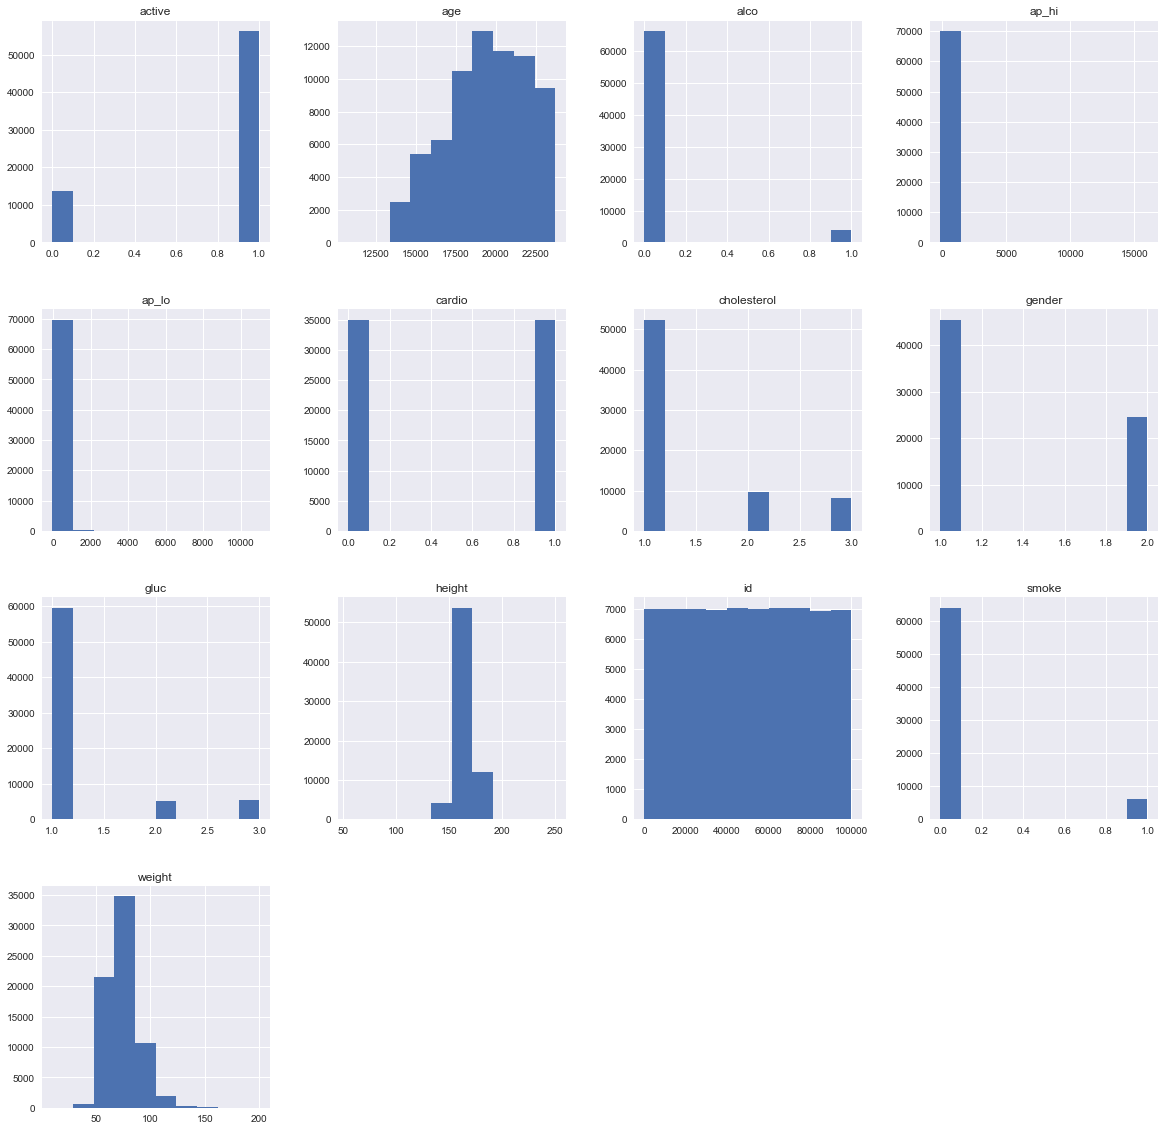

In [84]:
# histogram of each data type to understand data better
p = data_copy.hist(figsize = (20,20))

120.0 126.97901428571429
126.97901428571429 120.0


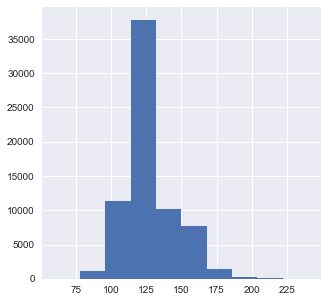

In [120]:
# ap_hi is positively skewed, replace invalid values with the median
hi_mean = np.mean(data_copy['ap_hi'])
hi_med = np.median(data_copy['ap_hi'])
print(hi_med, hi_mean)
# median < mean confirms right skew
data_copy.loc[data_copy['ap_hi'] > 240, 'ap_hi'] = hi_med
data_copy.loc[data_copy['ap_hi'] < 60, 'ap_hi'] = hi_med
np.sort(data_copy['ap_hi'])
c=data_copy['ap_hi'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['ap_hi'])
new_med = np.median(data_copy['ap_hi'])
print(new_mean, new_med)
# new mean and median are a bit closer, we'll take it

80.0 81.36022857142858
81.36022857142858 80.0


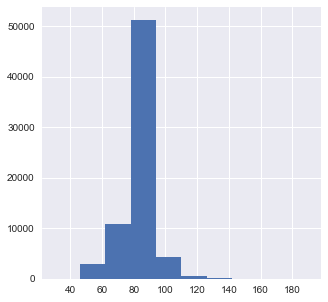

In [122]:
# ap_lo is right skewed as well, even more so than ap_hi, fix the same way, replace unrealistic values with median
lo_mean = np.mean(data_copy['ap_lo'])
lo_med = np.median(data_copy['ap_lo'])
print(lo_med, lo_mean)
# median < mean confirms right skew
data_copy.loc[data_copy['ap_lo'] > 190, 'ap_lo'] = lo_med
data_copy.loc[data_copy['ap_lo'] < 30, 'ap_lo'] = lo_med
np.sort(data_copy['ap_lo'])
c=data_copy['ap_lo'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['ap_lo'])
new_med = np.median(data_copy['ap_lo'])
print(new_mean, new_med)
# ap_lo didn't need much normalizing but at least absurd values are gone

72.0 74.23399785714287
74.23399785714287 72.0


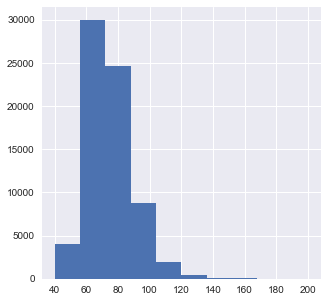

In [125]:
# now to fix the weights, looks a bit right skewed but will check mean and med to confirm
weight_mean = np.mean(data_copy['weight'])
weight_med = np.median(data_copy['weight'])
print(weight_med, weight_mean)
# median < mean confirms right skew, even if just barely, replace invalid values with median
data_copy.loc[data_copy['weight'] < 40, 'weight'] = weight_med
np.sort(data_copy['weight'])
c=data_copy['weight'].hist(figsize=(5,5))
new_mean = np.mean(data_copy['weight'])
new_med = np.median(data_copy['weight'])
print(new_mean, new_med)
# weight didn't need much normalizing either, but again, outlandish values are gone now

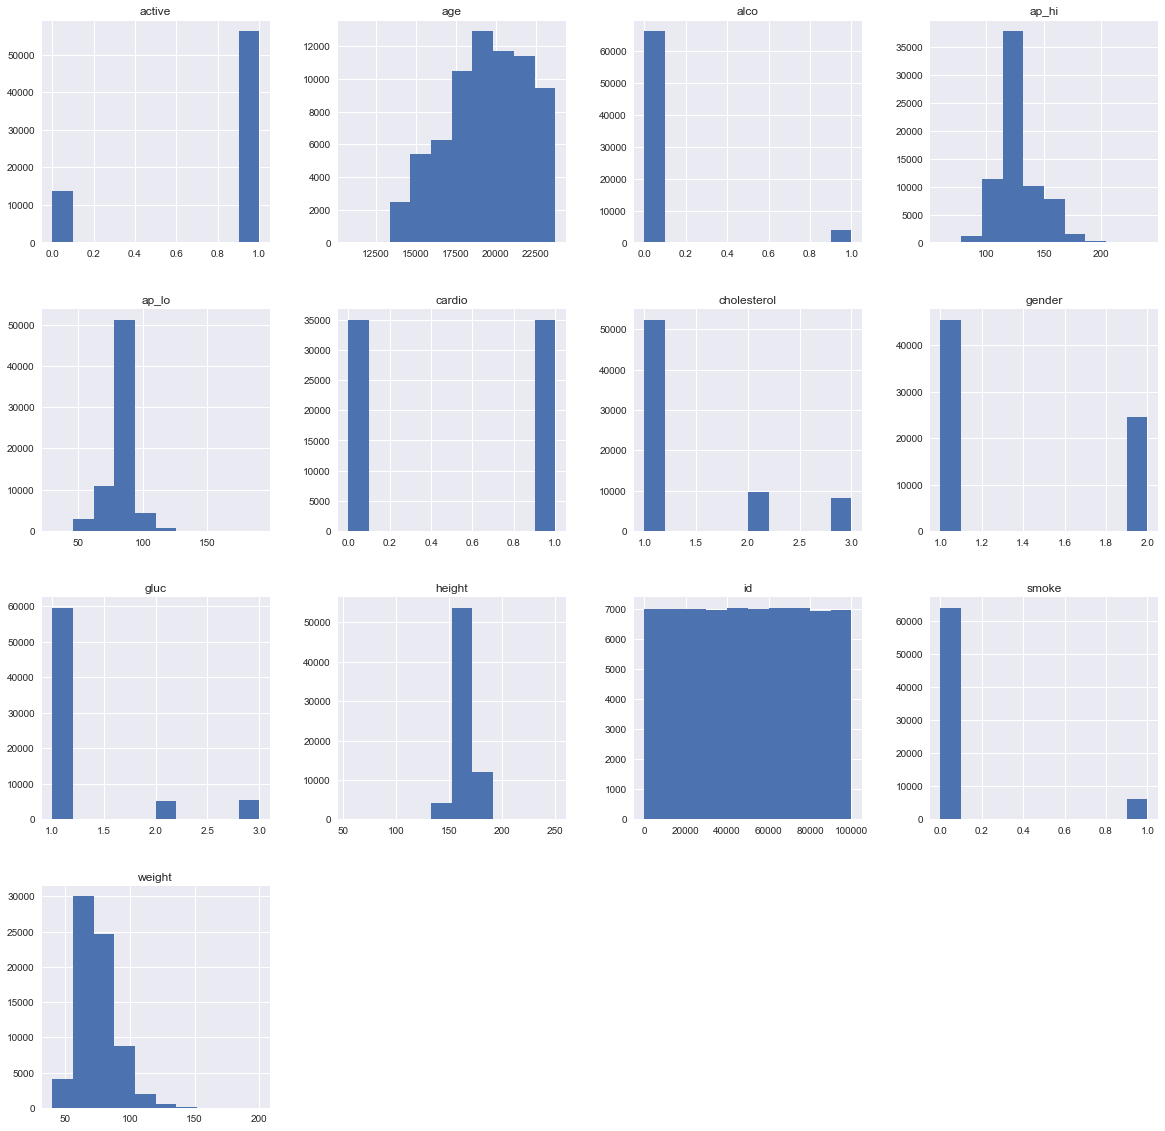

In [128]:
p = data_copy.hist(figsize = (20,20))